# 무지성 training 해보기

In [1]:
! pip install -U pandas-profiling

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import ADASYN
%matplotlib inline

In [3]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [4]:
train.columns.to_list()

['id',
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'type',
 'quality']

In [5]:
test.columns.to_list()

['id',
 'fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'type']

## 전처리

```type``` 변수를 categorical int(?)로 변경

In [6]:
train.loc[train['type']=='white', 'type'] = 0
train.loc[train['type']=='red', 'type'] = 1
train['type'] = train['type'].astype('int')
test.loc[test['type']=='white', 'type'] = 0
test.loc[test['type']=='red', 'type'] = 1
test['type'] = test['type'].astype('int')
train

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,1,8.0,0.18,0.37,1.30,0.040,15.0,96.0,0.99120,3.06,0.61,12.1,0,6
1,2,7.5,0.38,0.29,4.90,0.021,38.0,113.0,0.99026,3.08,0.48,13.0,0,7
2,3,6.1,0.27,0.33,2.20,0.021,26.0,117.0,0.98860,3.12,0.30,12.5,0,6
3,4,6.4,0.32,0.50,10.70,0.047,57.0,206.0,0.99680,3.08,0.60,9.4,0,5
4,5,8.4,0.37,0.43,2.30,0.063,12.0,19.0,0.99550,3.17,0.81,11.2,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3226,3227,6.4,0.16,0.31,5.30,0.043,42.0,157.0,0.99455,3.35,0.47,10.5,0,5
3227,3228,6.4,0.18,0.28,17.05,0.047,53.0,139.0,0.99724,3.25,0.35,10.5,0,6
3228,3229,6.0,0.28,0.25,1.80,0.042,8.0,108.0,0.99290,3.08,0.55,9.0,0,5
3229,3230,7.7,0.28,0.29,6.90,0.041,29.0,163.0,0.99520,3.44,0.60,10.5,0,6


Feature Selection

In [7]:
train = train[[
    # 'id',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    'type',
    'quality',
 ]]

test = test[[
    # 'id',
    'fixed acidity',
    'volatile acidity',
    'citric acid',
    'residual sugar',
    'chlorides',
    'free sulfur dioxide',
    'total sulfur dioxide',
    'density',
    'pH',
    'sulphates',
    'alcohol',
    'type',
 ]]

In [8]:
X_train = train.drop('quality', axis = 1)
y_train = train['quality']

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  type                  3231 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 303.0 KB


In [10]:
y_train

0       6
1       7
2       6
3       5
4       7
       ..
3226    5
3227    6
3228    5
3229    6
3230    7
Name: quality, Length: 3231, dtype: int64

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  type                  3231 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 303.0 KB


## 모델 준비

In [12]:
model = XGBClassifier(
    objective='multi:softprob',
)

In [13]:
'''
merror : #(wrong cases) / # (all cases), 틀린 비율, accuracy의 반대라고 생각하면된다
mlogloss : categorical cross entropy loss
'''
from sklearn.metrics import log_loss

loss_list = []
skf = StratifiedKFold(n_splits = 3)
for train_index, val_index in skf.split(X_train, y_train):
    print(train_index)
    train_x = X_train.iloc[train_index]
    train_y = y_train.iloc[train_index]
    val_x = X_train.iloc[val_index]
    val_y= y_train.iloc[val_index]
    model.fit(X=X_train,
              y=y_train,
              eval_set=[(val_x, val_y)],
              eval_metric=['merror','mlogloss'],
              early_stopping_rounds=30)
    loss = log_loss(y_true = val_y, y_pred = model.predict_proba(val_x))
    loss_list.append(loss)
print(f'loss_list = {loss_list}')

[1042 1043 1044 ... 3228 3229 3230]
[0]	validation_0-merror:0.446611	validation_0-mlogloss:1.54089
Multiple eval metrics have been passed: 'validation_0-mlogloss' will be used for early stopping.

Will train until validation_0-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-merror:0.443825	validation_0-mlogloss:1.48284
[2]	validation_0-merror:0.444754	validation_0-mlogloss:1.43173
[3]	validation_0-merror:0.443825	validation_0-mlogloss:1.38713
[4]	validation_0-merror:0.444754	validation_0-mlogloss:1.34783
[5]	validation_0-merror:0.43454	validation_0-mlogloss:1.31287
[6]	validation_0-merror:0.433612	validation_0-mlogloss:1.28209
[7]	validation_0-merror:0.433612	validation_0-mlogloss:1.25428
[8]	validation_0-merror:0.431755	validation_0-mlogloss:1.22948
[9]	validation_0-merror:0.421541	validation_0-mlogloss:1.20646
[10]	validation_0-merror:0.423398	validation_0-mlogloss:1.18552
[11]	validation_0-merror:0.420613	validation_0-mlogloss:1.1663
[12]	validation_0-merror:0.418756	validat

In [14]:
pred = model.predict(test)
pred_prob = model.predict_proba(test)

In [15]:
submission = pd.DataFrame({
    "id" : test.id,
    "quality":pred,
})
submission.to_csv('xgboost_submission.csv', index=False)

AttributeError: 'DataFrame' object has no attribute 'id'

## 결과 분석

In [16]:
pred = pd.DataFrame(pred)
pred_prob

array([[0.03053056, 0.17074002, 0.38287398, 0.37026954, 0.0455859 ],
       [0.01171091, 0.3204117 , 0.6591363 , 0.00578748, 0.00295359],
       [0.1068255 , 0.348887  , 0.4742907 , 0.06181047, 0.00818635],
       ...,
       [0.01366837, 0.7655141 , 0.18749109, 0.02298836, 0.01033814],
       [0.0040992 , 0.02094553, 0.35545975, 0.40400103, 0.21549448],
       [0.01033375, 0.09638185, 0.43603805, 0.36572936, 0.09151697]],
      dtype=float32)

In [18]:
pred[0].value_counts()

6    1893
5    1047
7     266
4      21
8       4
Name: 0, dtype: int64

<BarContainer object of 5 artists>

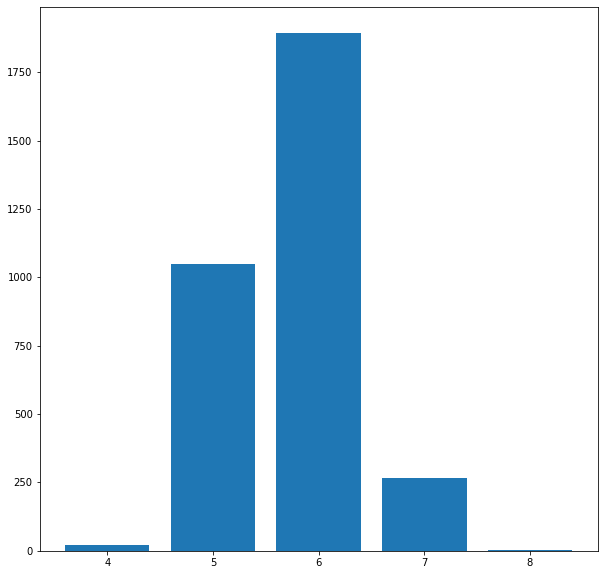

In [17]:
plt.subplots(1,1,figsize=(10,10))
plt.bar (x= pred[0].value_counts().index, height = pred[0].value_counts())

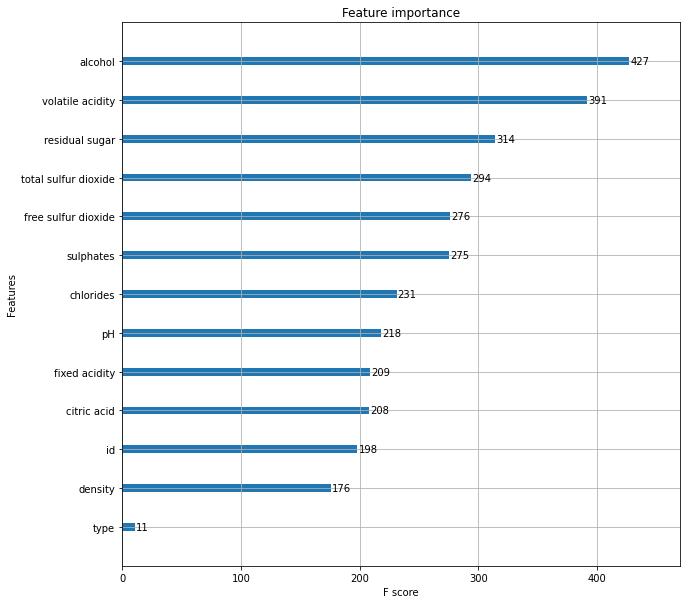

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
xgboost.plot_importance(model,ax)

# DATA IMBALANCE 해결하기 : ADASYN (Adaptive Synthetic Sampling)

SMOTE (Synthetic Minority OverSampling Technique)이 kNN을 이용해서 소수 클래스의 양을 증가시키는 방법이라면, ADASYN은 여기에 조금 더 미세한 값들을 더해줌으로써 분산을 증가시켜, 더 사실적인 데이터를 만드는 방법이다

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         3231 non-null   float64
 1   volatile acidity      3231 non-null   float64
 2   citric acid           3231 non-null   float64
 3   residual sugar        3231 non-null   float64
 4   chlorides             3231 non-null   float64
 5   free sulfur dioxide   3231 non-null   float64
 6   total sulfur dioxide  3231 non-null   float64
 7   density               3231 non-null   float64
 8   pH                    3231 non-null   float64
 9   sulphates             3231 non-null   float64
 10  alcohol               3231 non-null   float64
 11  type                  3231 non-null   int64  
 12  quality               3231 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 328.3 KB


기존 데이터를 분석해보면 다음과 같다. ```quality 4, 8```에 해당하는 데이터가 매우 부족한 것을 볼 수 있다. 

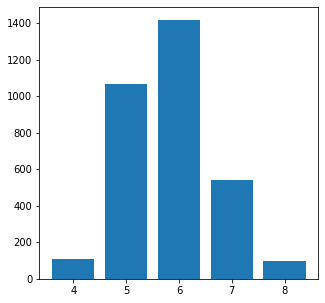

In [84]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
var = train['quality'].value_counts()
plt.bar(var.index, var)
plt.show()

ADASYN을 이용해 부족한 클래스들을 오버샘플링 해보자

In [69]:
ada = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = ada.fit_resample(X_train, y_train)   

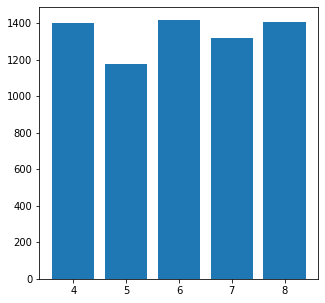

In [70]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
var = y_train_resampled.value_counts()
plt.bar(var.index, var)
plt.show()

모든 클래스가 거의 1300여개 정도로 Resampling된 것을 볼 수 있다. 데이터를 저장하자

In [71]:
X_train_resampled.to_csv('./dataset/X_train_resampled.csv', index_label=False)
y_train_resampled.to_csv('./dataset/y_train_resampled.csv', index_label=False)

# Optuna를 이용해 hyperparameter tuning 해보기

GROUP 1: max_depth , min_child_weight

GROUP 2: subsample, colsample_bytree

GROUP 3: learning_rate, num_boost_round

순차적으로 tuning을 진행한다. 한 그룹의 튜닝을 진행할 때, 다른 모든 그룹은 값을 고정한다. 튜닝을 진행한 값은 고정하여 이후에 다시 변하지 않는다. ```learing_rate, num_boos_round```는 각각 0.1과 1000으로 고정한다

In [46]:
import optuna
from sklearn.metrics import log_loss


# 순차적으로 업데이트를 진행할 것이기 때문에 params dict를 불러온다
def objective(trial, X, y, group, params=dict()):
    ## Initial Learning Parameters
    params['learning_rate'] = 0.1
    params['num_boost_round'] = 1000

    if group == '1':
        params['max_depth'] = trial.suggest_int('max_depth', 2, 10)
        params['min_child_weight'] = trial.suggest_loguniform(
            'min_child_weight', 1e-10, 1e10)

    if group == '2':
        params['subsample'] = trial.suggest_uniform('subsample', 0, 1)
        params['colsample_bytree'] = trial.suggest_uniform(
            'colsample_bytree', 0, 1)

    if group == '3':
        params['learning_rate'] = trial.suggest_uniform(
            'learning_rate', 0, 0.1)
        params['num_boost_round'] = trial.suggest_int('num_boost_round', 100,
                                                      1000)

    model = XGBClassifier(**params)
    loss_list = []
    skf = StratifiedKFold(n_splits = 3)
    for train_index, val_index in skf.split(X_train, y_train):
        # print(train_index)
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index]
        val_y= y_train.iloc[val_index]
        model.fit(X=X_train,
                y=y_train,
                eval_set=[(val_x, val_y)],
                eval_metric='mlogloss',
                early_stopping_rounds=30,
                verbose=False)
        loss = log_loss(y_true = val_y, y_pred = model.predict_proba(val_x))
        loss_list.append(loss)
    # print(f'loss_list = {loss_list}')

    # 평균 loss를 반환한다
    return np.array(loss_list).mean()

# 각 group마다 trials만큼 hyperparameter tuning을 실시한다
study_dict = dict()
def stepwise_optimization(trials=10):
    final_params = dict()

    for group_num in ['1', '2', '3']:
        print(
            f"=========================== Optimizing Group - {group_num} ============================"
        )

        study = optuna.create_study(direction='minimize')

        study.optimize(lambda trial : objective(trial, X_train, y_train, group=group_num, params=final_params), n_trials=trials)
        print("BEST CV SCORE", study.best_value)
        print(f"OPTIMAL GROUP - {group_num} PARAMS: ", study.best_params)
        
        final_params.update(study.best_params)

        study_dict[group_num] = study

    print(f'BEST SCORE : {study.best_value}')
    print(f"PARAMS after optimizing GROUP - {group_num}: ", final_params)
    print()
    print()

    print(
        "=========================== FINAL OPTIMAL PARAMETERS ============================"
    )
    print(final_params)

    return final_params

best_param = stepwise_optimization(10)


[I 2021-12-04 02:22:26,655] A new study created in memory with name: no-name-bef98215-dd70-4f1d-9f7a-12956484e89f


=========================== Optimizing Group - 1 ============================


[I 2021-12-04 02:22:29,296] Trial 0 finished with value: 1.244991797959609 and parameters: {'max_depth': 8, 'min_child_weight': 2493391108.868087}. Best is trial 0 with value: 1.244991797959609.
[I 2021-12-04 02:22:35,547] Trial 1 finished with value: 0.8135321887053782 and parameters: {'max_depth': 3, 'min_child_weight': 2.967080982998148}. Best is trial 1 with value: 0.8135321887053782.
[I 2021-12-04 02:22:41,936] Trial 2 finished with value: 0.9598393546643917 and parameters: {'max_depth': 10, 'min_child_weight': 135.0831671617442}. Best is trial 1 with value: 0.8135321887053782.
[I 2021-12-04 02:22:57,827] Trial 3 finished with value: 0.2731458132677829 and parameters: {'max_depth': 7, 'min_child_weight': 0.2797038374717507}. Best is trial 3 with value: 0.2731458132677829.
[I 2021-12-04 02:23:19,280] Trial 4 finished with value: 0.1177553661052035 and parameters: {'max_depth': 9, 'min_child_weight': 6.567166576162483e-05}. Best is trial 4 with value: 0.1177553661052035.
[I 2021-12-

BEST CV SCORE 0.06733497603718884
OPTIMAL GROUP - 1 PARAMS:  {'max_depth': 10, 'min_child_weight': 0.03886684436335368}
=========================== Optimizing Group - 2 ============================


[I 2021-12-04 02:24:23,723] Trial 0 finished with value: 0.7465076396747369 and parameters: {'subsample': 0.5164930323307895, 'colsample_bytree': 0.02730793266358833}. Best is trial 0 with value: 0.7465076396747369.
[I 2021-12-04 02:24:29,231] Trial 1 finished with value: 0.7248553699963383 and parameters: {'subsample': 0.7104843248067788, 'colsample_bytree': 0.04567862855052751}. Best is trial 1 with value: 0.7248553699963383.
[I 2021-12-04 02:24:51,774] Trial 2 finished with value: 0.07110559124184218 and parameters: {'subsample': 0.743723088074654, 'colsample_bytree': 0.8906325813331374}. Best is trial 2 with value: 0.07110559124184218.
[I 2021-12-04 02:25:01,720] Trial 3 finished with value: 0.12895649736409898 and parameters: {'subsample': 0.8426570260196562, 'colsample_bytree': 0.25336383023840536}. Best is trial 2 with value: 0.07110559124184218.
[I 2021-12-04 02:25:14,859] Trial 4 finished with value: 0.2573812009640734 and parameters: {'subsample': 0.2275051240049757, 'colsamp

BEST CV SCORE 0.06479897681425961
OPTIMAL GROUP - 2 PARAMS:  {'subsample': 0.8491720457696501, 'colsample_bytree': 0.86356915873729}
=========================== Optimizing Group - 3 ============================


[I 2021-12-04 02:26:47,281] Trial 0 finished with value: 0.15921561834807366 and parameters: {'learning_rate': 0.05697400983982549, 'num_boost_round': 989}. Best is trial 0 with value: 0.15921561834807366.
[I 2021-12-04 02:27:09,197] Trial 1 finished with value: 0.13963247049474212 and parameters: {'learning_rate': 0.06391019017540928, 'num_boost_round': 569}. Best is trial 1 with value: 0.13963247049474212.
[I 2021-12-04 02:27:31,669] Trial 2 finished with value: 0.6390078610880977 and parameters: {'learning_rate': 0.015469396112672862, 'num_boost_round': 474}. Best is trial 1 with value: 0.13963247049474212.
[I 2021-12-04 02:27:53,316] Trial 3 finished with value: 0.07854536343400496 and parameters: {'learning_rate': 0.09072308599135677, 'num_boost_round': 338}. Best is trial 3 with value: 0.07854536343400496.
[I 2021-12-04 02:28:15,201] Trial 4 finished with value: 0.13516463569003115 and parameters: {'learning_rate': 0.06491494322374053, 'num_boost_round': 182}. Best is trial 3 wit

BEST CV SCORE 0.07854536343400496
OPTIMAL GROUP - 3 PARAMS:  {'learning_rate': 0.09072308599135677, 'num_boost_round': 338}
BEST SCORE : 0.07854536343400496
PARAMS after optimizing GROUP - 3:  {'learning_rate': 0.09072308599135677, 'num_boost_round': 338, 'max_depth': 10, 'min_child_weight': 0.03886684436335368, 'subsample': 0.8491720457696501, 'colsample_bytree': 0.86356915873729}


=========================== FINAL OPTIMAL PARAMETERS ============================
{'learning_rate': 0.09072308599135677, 'num_boost_round': 338, 'max_depth': 10, 'min_child_weight': 0.03886684436335368, 'subsample': 0.8491720457696501, 'colsample_bytree': 0.86356915873729}


In [ ]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
# optuna.visualization.plot_param_importances(study_dict['3'])

In [ ]:
# 하이퍼파라미터 최적화 과정을 확인
# optuna.visualization.plot_optimization_history(study_dict['3'])

In [58]:
import pickle
with open ('./best_param.pkl', 'wb') as f:
    pickle.dump(best_param, f)